In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import necessary libraries

from os.path import join
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
#!pip install --upgrade tensorflow-model-optimization

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
import random
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix
from skimage import transform
from skimage import color, exposure, morphology, measure
from scipy.ndimage import median_filter
from skimage import feature
from skimage.filters import frangi
from skimage.measure import shannon_entropy
from skimage.morphology import binary_erosion, binary_dilation, disk
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set the path to your dataset
data_dir = "/content/drive/MyDrive/Self Collected_Dataset"

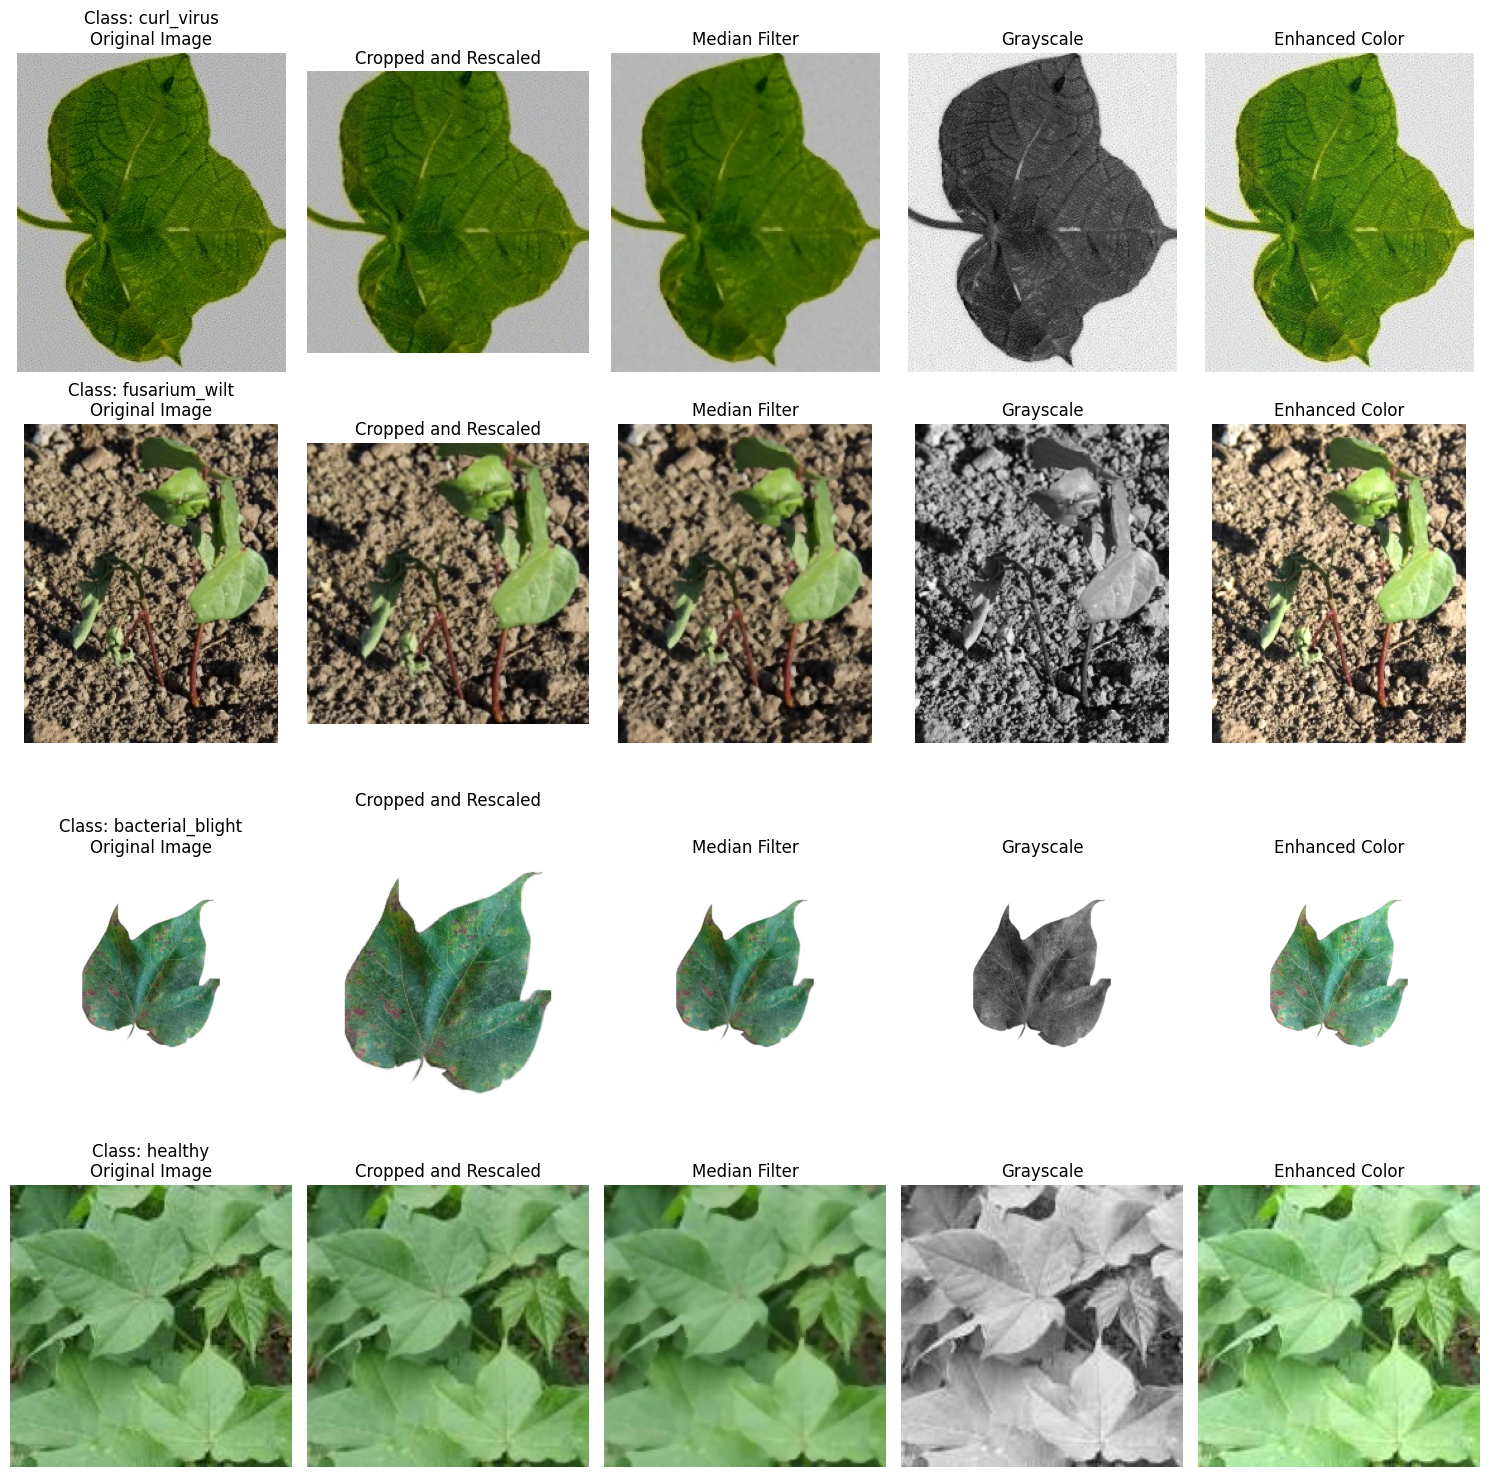

In [ ]:
# Step 1: Data Preprocessing (Croping, resizing, rescaling, median filtering, color transformation and color enhancement technique)
#Function to preprocess image
def preprocess_image(image, target_size=(224, 224), scale_factor=1.0):
    # Crop the center of the image
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    crop_size = min(center_x, center_y)
    cropped_image = image[center_y - crop_size: center_y + crop_size, center_x - crop_size: center_x + crop_size]

    # Resize the image
    resized_image = cv2.resize(cropped_image, target_size)

    # Rescale the image
    rescaled_image = resized_image * scale_factor

    return rescaled_image / 255.0

# Function for median filter
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

# Function for color transformation
def transform_color(image, target_color=cv2.COLOR_BGR2GRAY):
    return cv2.cvtColor(image, target_color)

# Function for color enhancement
def enhance_color(image, alpha=1.2, beta=10):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Load and preprocess images from a sample multiclass dataset
base_path = "/content/drive/MyDrive/Self Collected_Dataset"
class_folders = os.listdir(base_path)

plt.figure(figsize=(15, 15))

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(base_path, class_folder)
    image_files = os.listdir(class_path)
    image_path = os.path.join(class_path, image_files[0])  # Take the first image for visualization

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Apply preprocessing techniques
    cropped_rescaled_image = preprocess_image(original_image)
    median_filtered_image = apply_median_filter(original_image)
    grayscale_image = transform_color(original_image, cv2.COLOR_BGR2GRAY)
    enhanced_image = enhance_color(original_image)

    # Visualize original and preprocessed images
    plt.subplot(len(class_folders), 5, i * 5 + 1)
    plt.imshow(original_image)
    plt.title(f'Class: {class_folder}\nOriginal Image')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 2)
    plt.imshow(cropped_rescaled_image)
    plt.title('Cropped and Rescaled')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 3)
    plt.imshow(median_filtered_image)
    plt.title('Median Filter')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 4)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 5)
    plt.imshow(enhanced_image)
    plt.title('Enhanced Color')
    plt.axis('off')

plt.tight_layout()
plt.show()

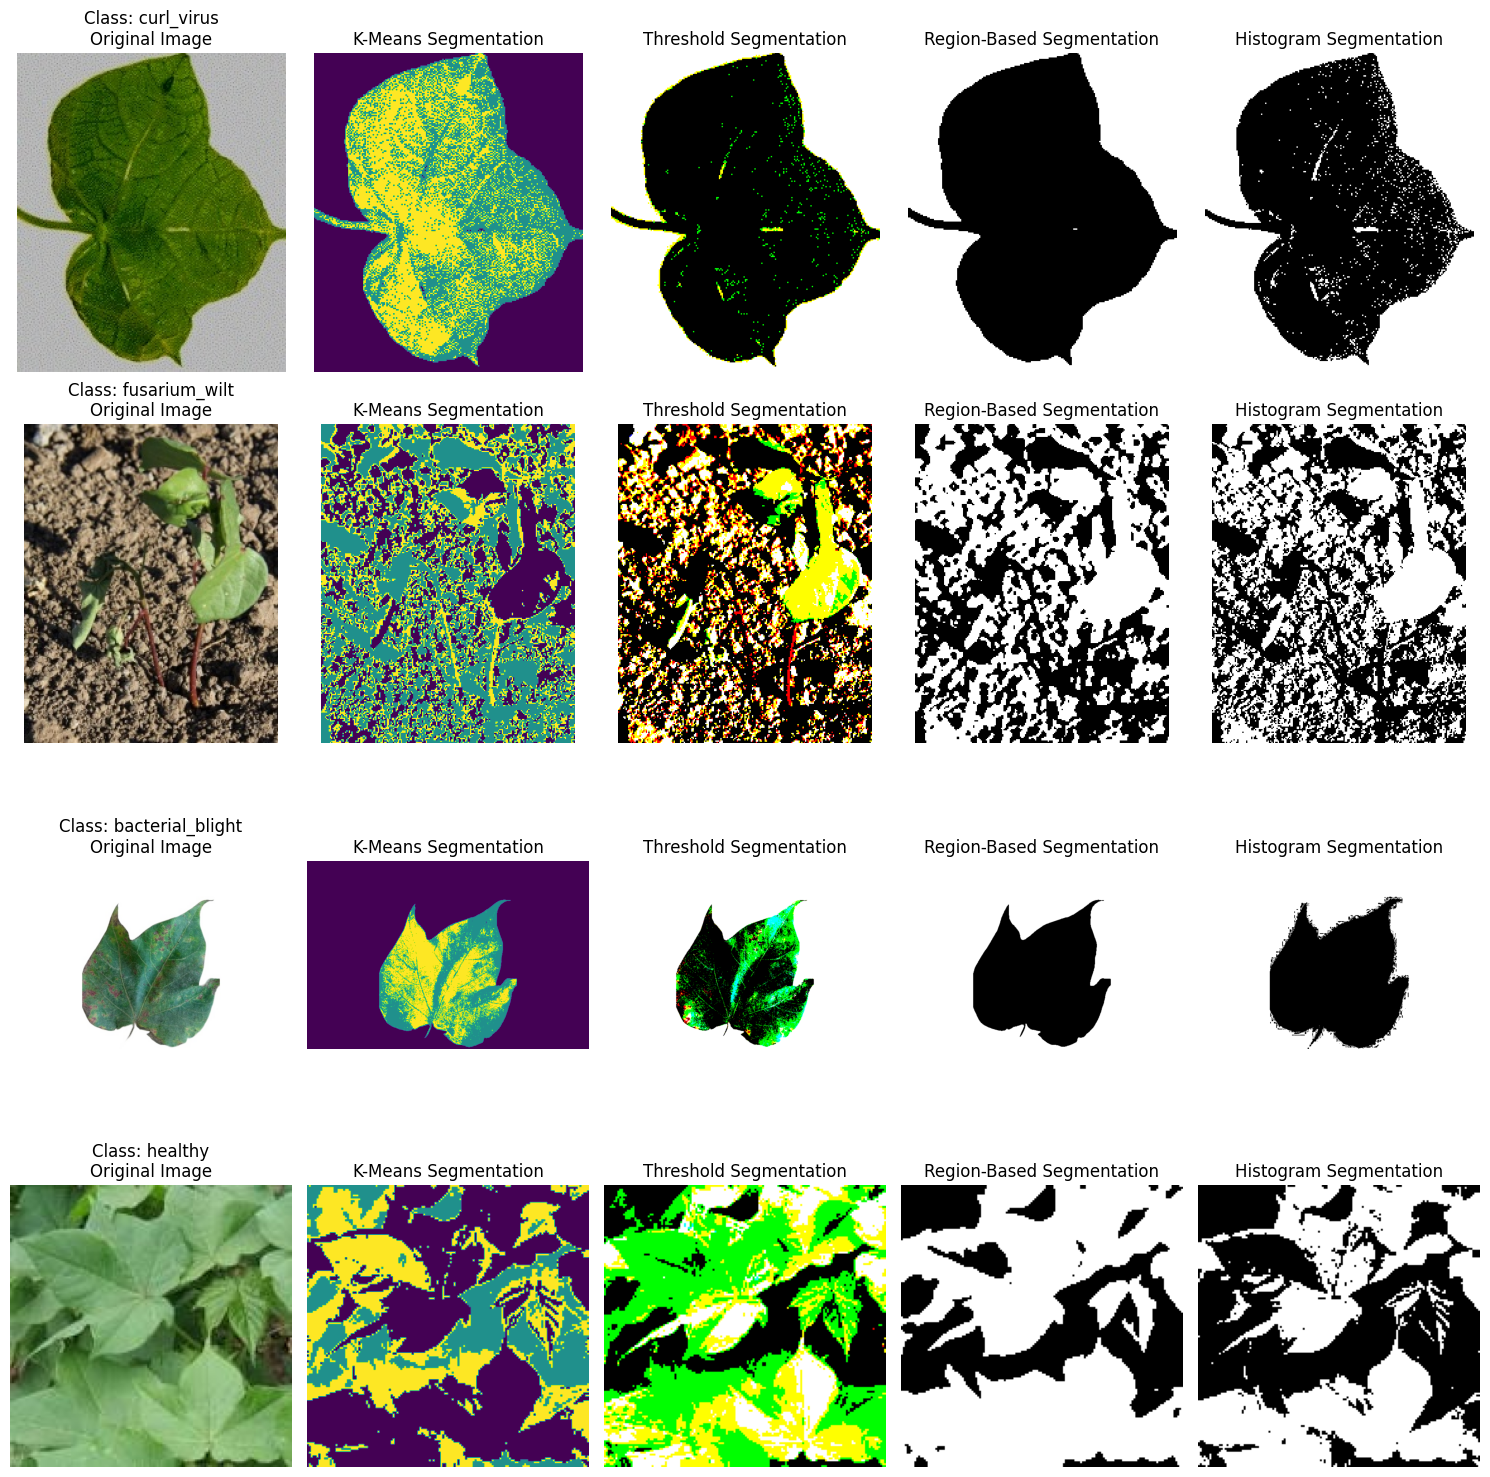

In [ ]:
# Step 2: Data Segmentation (K-means clustering, thresholding, region-based segmentation, histogram-based segmentation Technique)
#Function for k-means clustering segmentation
def kmeans_segmentation(image, num_clusters=3):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(pixels)
    segmented_image = kmeans.labels_.reshape(image.shape[:2])
    return segmented_image

# Function for thresholding segmentation
def threshold_segmentation(image, threshold_value=128):
    _, segmented_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return segmented_image

# Function for region-based segmentation
def region_segmentation(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return segmented_image

# Function for histogram-based segmentation
def histogram_segmentation(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate histogram
    hist, bins = np.histogram(gray_image.flatten(), 256, [0, 256])

    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()

    # Normalize CDF
    cdf_normalized = cdf / cdf.max()

    # Perform histogram equalization
    equalized_image = np.interp(gray_image.flatten(), bins[:-1], cdf_normalized * 255).reshape(gray_image.shape)

    # Apply Otsu's thresholding to the equalized image
    _, segmented_image = cv2.threshold(equalized_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return segmented_image

# Example usage for a multiclass dataset
base_path = "/content/drive/MyDrive/Self Collected_Dataset"
class_folders = os.listdir(base_path)

plt.figure(figsize=(15, 15))

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(base_path, class_folder)
    image_files = os.listdir(class_path)
    image_path = os.path.join(class_path, image_files[0])  # Take the first image for visualization

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Apply segmentation techniques
    kmeans_segmented_image = kmeans_segmentation(original_image)
    threshold_segmented_image = threshold_segmentation(original_image)
    region_segmented_image = region_segmentation(original_image)
    histogram_segmented_image = histogram_segmentation(original_image)

    # Visualize original and segmented images
    plt.subplot(len(class_folders), 5, i * 5 + 1)
    plt.imshow(original_image)
    plt.title(f'Class: {class_folder}\nOriginal Image')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 2)
    plt.imshow(kmeans_segmented_image, cmap='viridis')
    plt.title('K-Means Segmentation')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 3)
    plt.imshow(threshold_segmented_image, cmap='gray')
    plt.title('Threshold Segmentation')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 4)
    plt.imshow(region_segmented_image, cmap='gray')
    plt.title('Region-Based Segmentation')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 5)
    plt.imshow(histogram_segmented_image, cmap='gray')
    plt.title('Histogram Segmentation')
    plt.axis('off')

plt.tight_layout()
plt.show()


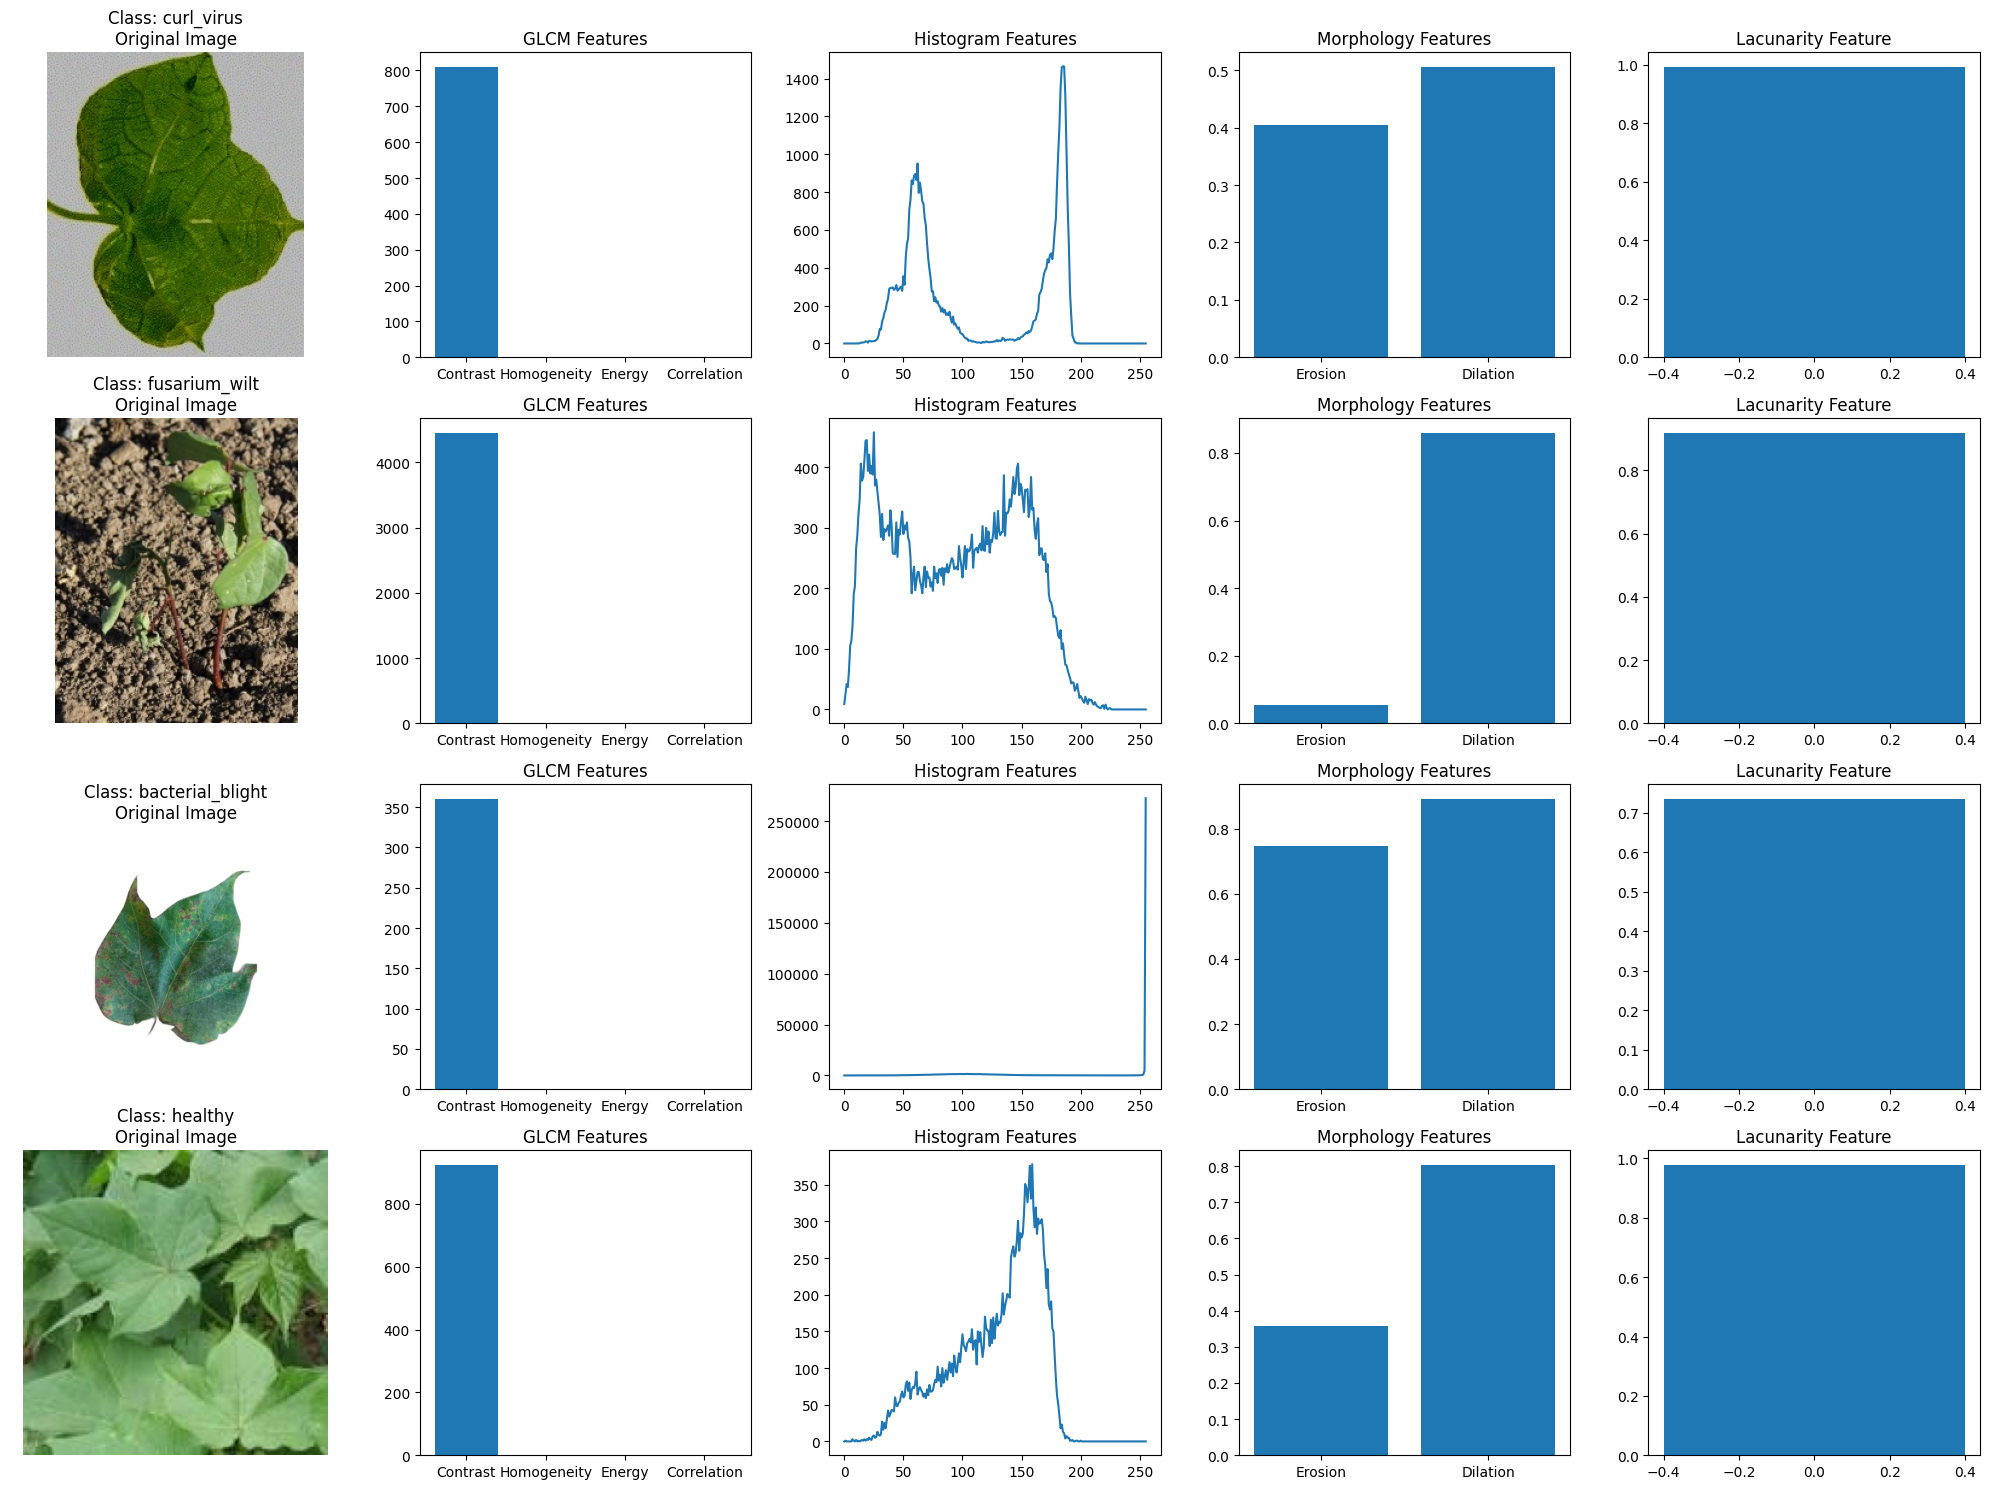

In [ ]:
# Step 3: Feature Extraction (GLCM, Histogram-based feature extraction, Morphology-based featrue extraction, Lacunarity-based feature extraction Technique)
#Function for GLCM-based feature extraction
def extract_glcm_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = feature.graycomatrix(gray_image, [5], [0], symmetric=True, normed=True)
    contrast = np.mean(feature.graycoprops(glcm, 'contrast'))
    homogeneity = np.mean(feature.graycoprops(glcm, 'homogeneity'))
    energy = np.mean(feature.graycoprops(glcm, 'energy'))
    correlation = np.mean(feature.graycoprops(glcm, 'correlation'))
    return [contrast, homogeneity, energy, correlation]

# Function for histogram-based feature extraction
def extract_histogram_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist, _ = np.histogram(gray_image.flatten(), bins=256, range=[0, 256])
    return hist

# Function for morphology-based feature extraction
def extract_morphology_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    erosion = binary_erosion(binary_image, disk(3))
    dilation = binary_dilation(binary_image, disk(3))
    return [np.mean(erosion), np.mean(dilation)]

# Function for lacunarity-based feature extraction
def extract_lacunarity_feature(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    return shannon_entropy(binary_image)

# Load and extract features from images in a sample multiclass dataset
base_path = "/content/drive/MyDrive/Self Collected_Dataset"
class_folders = os.listdir(base_path)

plt.figure(figsize=(20, 15))

for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(base_path, class_folder)
    image_files = os.listdir(class_path)
    image_path = os.path.join(class_path, image_files[0])  # Take the first image for visualization

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Extract features using different techniques
    glcm_features = extract_glcm_features(original_image)
    histogram_features = extract_histogram_features(original_image)
    morphology_features = extract_morphology_features(original_image)
    lacunarity_feature = extract_lacunarity_feature(original_image)

    # Visualize original image and extracted features
    plt.subplot(len(class_folders), 5, i * 5 + 1)
    plt.imshow(original_image)
    plt.title(f'Class: {class_folder}\nOriginal Image')
    plt.axis('off')

    plt.subplot(len(class_folders), 5, i * 5 + 2)
    plt.bar(range(len(glcm_features)), glcm_features)
    plt.title('GLCM Features')
    plt.xticks(range(len(glcm_features)), ['Contrast', 'Homogeneity', 'Energy', 'Correlation'])

    plt.subplot(len(class_folders), 5, i * 5 + 3)
    plt.plot(histogram_features)
    plt.title('Histogram Features')

    plt.subplot(len(class_folders), 5, i * 5 + 4)
    plt.bar(range(len(morphology_features)), morphology_features)
    plt.title('Morphology Features')
    plt.xticks(range(len(morphology_features)), ['Erosion', 'Dilation'])

    plt.subplot(len(class_folders), 5, i * 5 + 5)
    plt.bar([0], [lacunarity_feature])
    plt.title('Lacunarity Feature')

plt.tight_layout()
plt.show()

In [ ]:
# Create an ImageDataGenerator for data augmentation         Data Augmentation
# It generate more images using below parameters
dataset_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
augmented_data = dataset_datagen.flow_from_directory(data_dir,    # this is the target directory
                                      target_size=(224, 224),    # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')      # since we use binary_crossentropy loss, we need binary labels

Found 573 images belonging to 4 classes.


In [ ]:
augmented_data.class_indices

{'bacterial_blight': 0, 'curl_virus': 1, 'fusarium_wilt': 2, 'healthy': 3}

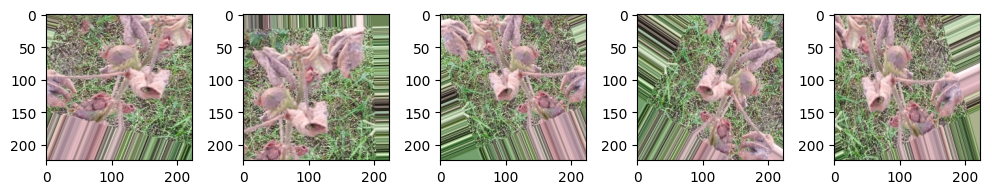

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

images = [augmented_data[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
classes = ["healthy", "bacterial_blight", "curl_virus", "fusarium_wilt"]
img_size = (224, 224)

def load_and_preprocess_data(data_dir, classes):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}. Skipping.")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            if not os.path.exists(img_path):
                print(f"Warning: Image not found at {img_path}. Skipping.")
                continue

            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Failed to read image at {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(classes.index(class_name))

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

data, labels = load_and_preprocess_data(data_dir, classes)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
#Building cnn model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), # neural network beulding
    tf.keras.layers.Dense(units=128, activation='relu'), # input layers
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=4, activation='softmax') # output layer
])


In [ ]:
# compile cnn model
cnn_model.compile(optimizer = Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 28, 28, 128)      

In [ ]:
model_path1 = '/content/drive/MyDrive/training_models/cnn_model_predictor.h5'
checkpoint = ModelCheckpoint(model_path1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# train cnn model
history = cnn_model.fit(X_train, y_train,
                          epochs=200,
                          verbose=1,
                          batch_size =16,
                          validation_split=0.1,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.4563
Epoch 1: val_accuracy improved from -inf to 0.63043, saving model to /content/drive/MyDrive/training_models/cnn_model_predictor.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 6s 157ms/step - loss: 1.1997 - accuracy: 0.4563 - val_loss: 0.9917 - val_accuracy: 0.6304
Epoch 2/200
25/26 [===========================>..] - ETA: 0s - loss: 0.8381 - accuracy: 0.6475
Epoch 2: val_accuracy improved from 0.63043 to 0.82609, saving model to /content/drive/MyDrive/training_models/cnn_model_predictor.h5
26/26 [==============================] - 2s 68ms/step - loss: 0.8365 - accuracy: 0.6505 - val_loss: 0.5835 - val_accuracy: 0.8261
Epoch 3/200
25/26 [===========================>..] - ETA: 0s - loss: 0.6478 - accuracy: 0.7425
Epoch 3: val_accuracy improved from 0.82609 to 0.89130, saving model to /content/drive/MyDrive/training_models/cnn_model_predictor.h5
26/26 [==============================] - 2s 65ms/step - loss: 0.6425 - accuracy: 0.7451 - val_loss: 0.4108 - val_accuracy: 0.8913
Epoch 4/200
25/26 [===========================>..] - ETA: 0s - loss: 0.5200 - accuracy: 0.7925
Epoch 4: val_accuracy improved from 0.89130 to 0.91304, 

In [ ]:
# Evaluate the Proposed CNN model
print("[INFO] Calculating model accuracy")
scores = cnn_model.evaluate(X_train, y_train)
print(f"Accuracy: {round(scores[1], 4) * 100}%")


[INFO] Calculating model accuracy


NameError: name 'cnn_model' is not defined

In [ ]:

cnn_predictions_train = cnn_model.predict(X_train)
cnn_predictions_train = np.argmax(cnn_predictions_train, axis=1)


15/15 [==============================] - 0s 28ms/step


In [ ]:
cnn_eval_train = cnn_model.evaluate(X_train, y_train)
cnn_accuracy = cnn_eval_train

15/15 [==============================] - 0s 30ms/step - loss: 0.0350 - accuracy: 0.9956


In [ ]:
cnn_eval_train

[0.03501274064183235, 0.9956331849098206]

In [ ]:
class_labels = ["bacterial blight", "fusarium wilt", "curl virus", "healthy"]
def evaluate_model(cnn_predictions_train, y_train, model_name):
    accuracy = accuracy_score(y_train, cnn_predictions_train)
    precision = precision_score(y_train, cnn_predictions_train, average='weighted')
    recall = recall_score(y_train, cnn_predictions_train, average='weighted')
    f1 = f1_score(y_train, cnn_predictions_train, average='weighted')
    conf_matrix = confusion_matrix(y_train, cnn_predictions_train)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_report = classification_report(y_train, cnn_predictions_train, target_names=class_labels)
    print('Classification Report:')
    print(class_report)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

     # Return the metrics
    return accuracy, precision, recall, f1


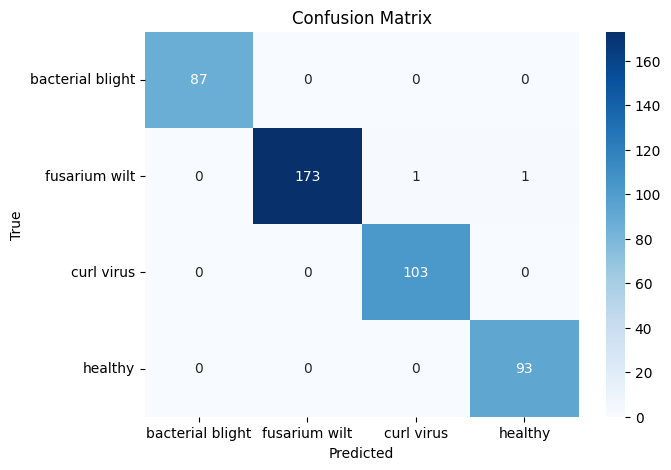

Classification Report:
                  precision    recall  f1-score   support

bacterial blight       1.00      1.00      1.00        87
   fusarium wilt       1.00      0.99      0.99       175
      curl virus       0.99      1.00      1.00       103
         healthy       0.99      1.00      0.99        93

        accuracy                           1.00       458
       macro avg       0.99      1.00      1.00       458
    weighted avg       1.00      1.00      1.00       458

Results for CNN:
Accuracy: 0.9956331877729258
Precision: 0.9956774097870911
Recall: 0.9956331877729258
F1 Score: 0.9956317513739998


In [ ]:
accuracy, precision, recall, f1 = evaluate_model(cnn_predictions_train, y_train, "CNN")

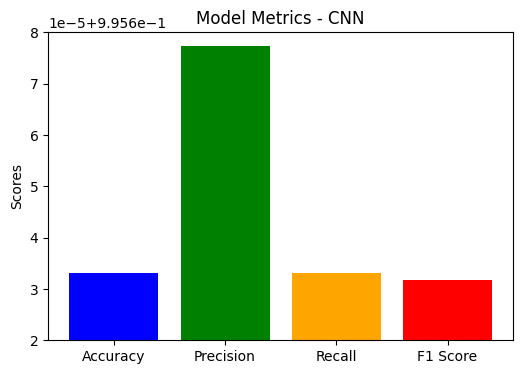

In [ ]:
def plot_metrics_train(accuracy, precision, recall, f1, model_name):
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metrics_values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
    plt.title(f'Model Metrics - {model_name}')
    plt.ylabel('Scores')
    plt.ylim([0.99562, 0.99568])  # Set the y-axis limit to better visualize scores between 0 and 1
    plt.show()
    # Plotting the metrics
plot_metrics_train(accuracy, precision, recall, f1, "CNN")

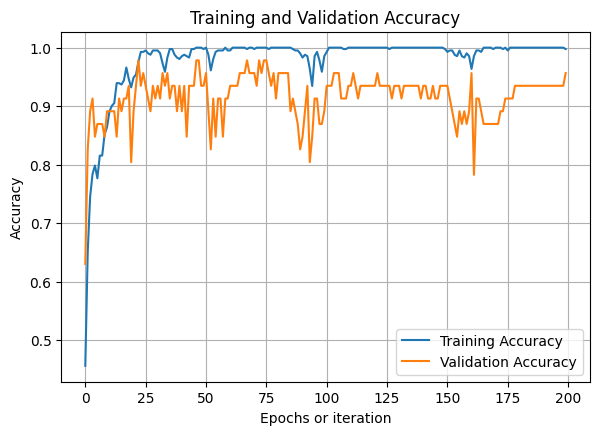

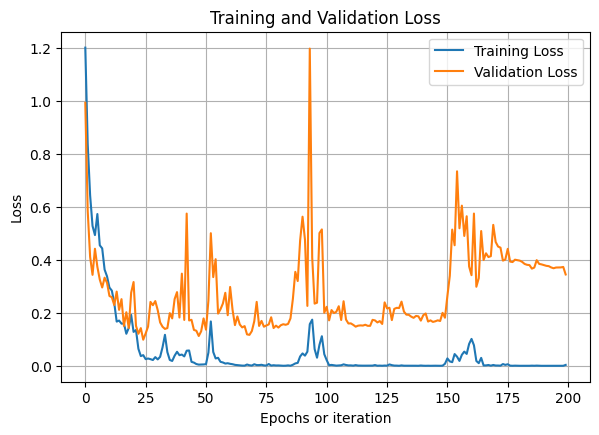

In [ ]:
#plt.figure(figsize=(10, 5))
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
# (2,2) means Width and Height of Diagram
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs or iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs or iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()